In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [3]:
# options
dataset = 'cifar10' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

In [4]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [5]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 128, 5)
        self.linear1 = nn.Linear(128*5*5, 64)
        self.linear2 = nn.Linear(64, 10)
         

    def forward(self, input):
        #input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = F.max_pool2d(torch.tanh(self.conv1(input)), 2)
        output = F.max_pool2d(torch.tanh(self.conv2(output)), 2)
        output = torch.flatten(output, 1)
        output = torch.tanh(self.linear1(output))
        output = self.linear2(output)
    
        return output

network = Net(num_inputs, num_outputs).cuda()
optimizer = optim.SGD(network.parameters(), lr=lr)

In [6]:
def train(epoch_nums):
    network.train()
    for epoch in range(epoch_nums):
      print("Starting train epoch ", epoch+1)
      for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, (batch_idx+1) * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data = data.cuda()
        target = target.cuda()
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [7]:
train(20)

Starting train epoch  1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.128841
Train Epoch: 1 [12800/50000 (25%)]	Loss: 2.012366
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.005077
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.910277
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.048770
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.855513
Train Epoch: 1 [44800/50000 (89%)]	Loss: 1.884568
Starting train epoch  2
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.691706
Train Epoch: 2 [12800/50000 (25%)]	Loss: 1.978198
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.799113
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.695851
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.657843
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.632947
Train Epoch: 2 [44800/50000 (89%)]	Loss: 1.723193
Starting train epoch  3
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.680063
Train Epoch: 3 [12800/50000 (25%)]	Loss: 1.907557
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.584166
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.632419
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.551185
Train

In [8]:
test()


Test set: Average loss: 0.9658, Accuracy: 6549/10000 (65%)



# Filter visualization

In [43]:
layer1 = network.conv1
weight = layer1.weight.data.clone()
tensor = layer1.weight.data.cpu().numpy()
tensor = tensor.reshape(16, 5, 5, 3)

In [44]:
import matplotlib.pyplot as plt
from torchvision import utils
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

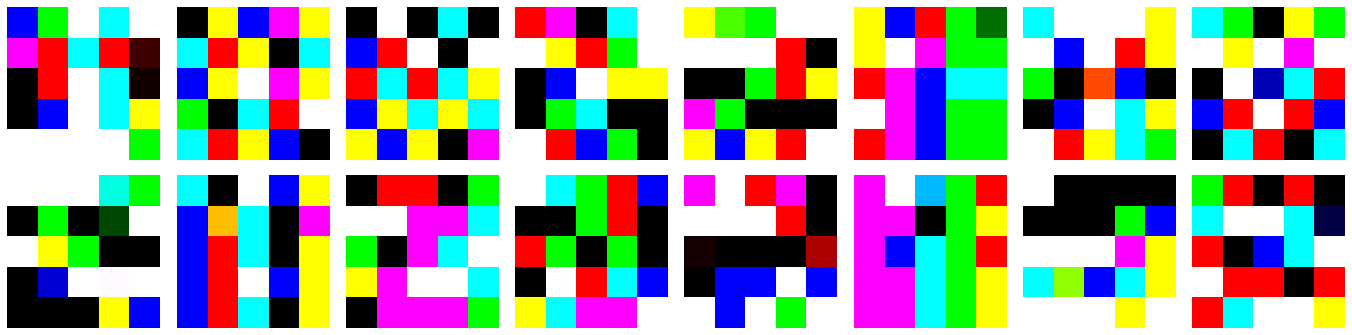

In [52]:

def plot_kernels(tensor, num_cols=8):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    

    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols*3,num_rows*3))

    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i]*255)
        ax1.axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

plot_kernels(tensor)

# Break down of parameters of each layer and overall number

In [53]:
from torchsummary import summary
summary(network, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]           1,216
            Conv2d-2          [-1, 128, 10, 10]          51,328
            Linear-3                   [-1, 64]         204,864
            Linear-4                   [-1, 10]             650
Total params: 258,058
Trainable params: 258,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.19
Params size (MB): 0.98
Estimated Total Size (MB): 1.19
----------------------------------------------------------------
